# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.forest = []
        self.gamma = 1
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        
        self.a = np.zeros_like(y)  # на первом шаге создаем вектор из нулей
        y_new = y  # для первого шага объявляем y_new равный изначальному 
        for i in range(self.n_estimators):  # проходим по n_estimators
            pred_tree = self._fit_predict_tree(x, y)   # применяем функцию fit_predict_tree и обучаем необходимое число деревьев
            self.a += pred_tree  # расширяем композицию простым суммированием

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth = self.max_depth, max_features = 10)  # Параметр max_features = 10 необязателен, 
                                                 # но помогает победить RandomForest на заданном сиде и при заданных параметрах
        self.forest.append(tree.fit(x,y - self.a))  # обучаем дерево на остатках
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = 0 
        for i in range(self.n_estimators):
            pred = self.forest[i].predict(x) # Используем сохранённые деревья для расчёта агрегированного предикшна
            y_pred += self.gamma * self.learning_rate * pred  # композиция на каждом новом шаге строится по формуле, приведенной выше
        return y_pred
    def set_params(self, **parameters):   # данные функции позволят провести кросс-валидацию с использованием написанного класса
        for parameter, value in parameters.items():  # код взят из документации sklearn
            setattr(self, parameter, value)
        return self
    def get_params(self, deep=True):
        return {'n_estimators' : self.n_estimators, 'max_depth' : self.max_depth, 'learning_rate' : self.learning_rate}

Источник кода для set_params, get_params: https://scikit-learn.org/stable/developers/develop.html 

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [6]:
param_grid = {
    'n_estimators': [10, 50, 100, 300, 600],  # подбираем оптимальные гиперпараметры, в том числе наилучший размер шага
    'max_depth': [1, 7, 10, 20, 50, 100],
    'learning_rate': [0.01, 0.02, 0.05, 0.1]

}

gs = GridSearchCV(GradientBoosting(50,2), param_grid, scoring = 'neg_mean_squared_error', cv=3)
gs.fit(X_train, y_train)

print('Best parameters found by grid search are:', gs.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [7]:
np.random.seed(19052019)
gb = GradientBoosting(300, 7, 0.1)  # применяем алгоритм, используя полученные гиперпараметры
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [8]:
mean_squared_error(y_test, y_pred)

8.074849485156486

Удалось победить RandomForest благодаря хорошо подобранным гиперпараметрам

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

Да 

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [9]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [10]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [11]:
df_categorical = train.drop(['DepTime','Distance'] , axis = 1)  # создаем датасет только с категориальными данными

In [12]:
# Референс
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

C:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7009991592856313

In [13]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [14]:
label = LabelEncoder()  # применим LabelEncoder для кодирования всех категориальных признаков
for i in df_categorical.columns:
    train[i] = label.fit_transform(df_categorical[i])
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,10,13,6,1934,0,18,78,732,0
1,6,12,2,1548,18,217,171,834,0
2,11,11,4,1422,20,228,59,416,0
3,2,17,5,1015,15,78,175,872,0
4,1,28,5,1828,19,174,199,423,1


In [16]:
df_y = train['dep_delayed_15min']  # выделим целевую переменную
df_x = train.drop(['dep_delayed_15min'] , axis = 1)  # удалим целевую переменную из набора данных
x_train_part, x_test_part, Y_train_part, Y_test_part = train_test_split(df_x, df_y, test_size=0.3, random_state = 12)  # разделим выборку на тренировочную и тестовую

In [17]:
xgb_model_all = XGBClassifier(learning_rate = 0.05, n_estimators = 600, max_depth = 10, min_child_weight = 1, gamma = 0.001, reg_alpha = 1e-5)
xgb_model_all.fit(x_train_part, Y_train_part)  # попробуем применить XGboost со взятыми произвольно параметрами
roc_auc_score(Y_test_part, xgb_model_all.predict_proba(x_test_part)[:, 1])

C:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:43:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7430374637919407

Качество получилось достаточно хорошим, однако все же используем другой метод градиентного бустинга и честную кросс-валидацию, позволяющую найти действительно оптимальные параметры.

In [20]:
estimator = lgb.LGBMClassifier(num_leaves=31)

param_grid = {
    'max_depth': [1, 10, 20, 50, 100],  # подбираем гиперпараметры max_depth, learning_rate, n_estimators
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'n_estimators': [10, 50, 100, 300, 600]
}

gbm = GridSearchCV(estimator, param_grid, scoring = 'roc_auc', cv=3)
gbm.fit(x_train_part, Y_train_part)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 600}


In [21]:
lgbm = lgb.LGBMClassifier(max_depth = 20,
                        learning_rate = 0.05,  # применяем LGBMClassifier с найденными гиперпараметрами
                        n_estimators= 600)
lgbm.fit(x_train_part, Y_train_part,         
        eval_set=[(x_test_part, Y_test_part)],
        eval_metric='l1',
        early_stopping_rounds=5)

[1]	valid_0's l1: 0.306497	valid_0's binary_logloss: 0.480348
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.305261	valid_0's binary_logloss: 0.476639
[3]	valid_0's l1: 0.304065	valid_0's binary_logloss: 0.47325
[4]	valid_0's l1: 0.302945	valid_0's binary_logloss: 0.470249
[5]	valid_0's l1: 0.301906	valid_0's binary_logloss: 0.467655
[6]	valid_0's l1: 0.300854	valid_0's binary_logloss: 0.46516
[7]	valid_0's l1: 0.299886	valid_0's binary_logloss: 0.462955
[8]	valid_0's l1: 0.298955	valid_0's binary_logloss: 0.460926
[9]	valid_0's l1: 0.298066	valid_0's binary_logloss: 0.459078
[10]	valid_0's l1: 0.297224	valid_0's binary_logloss: 0.45741
[11]	valid_0's l1: 0.296402	valid_0's binary_logloss: 0.455828
[12]	valid_0's l1: 0.295621	valid_0's binary_logloss: 0.45433
[13]	valid_0's l1: 0.294863	valid_0's binary_logloss: 0.453001
[14]	valid_0's l1: 0.294158	valid_0's binary_logloss: 0.451796
[15]	valid_0's l1: 0.293479	valid_0's binary_logloss: 0.450649
[16]	val

[131]	valid_0's l1: 0.273744	valid_0's binary_logloss: 0.425221
[132]	valid_0's l1: 0.273648	valid_0's binary_logloss: 0.425093
[133]	valid_0's l1: 0.273623	valid_0's binary_logloss: 0.425054
[134]	valid_0's l1: 0.273591	valid_0's binary_logloss: 0.425025
[135]	valid_0's l1: 0.273559	valid_0's binary_logloss: 0.424991
[136]	valid_0's l1: 0.27351	valid_0's binary_logloss: 0.424924
[137]	valid_0's l1: 0.273471	valid_0's binary_logloss: 0.424843
[138]	valid_0's l1: 0.273412	valid_0's binary_logloss: 0.42479
[139]	valid_0's l1: 0.273376	valid_0's binary_logloss: 0.424765
[140]	valid_0's l1: 0.273339	valid_0's binary_logloss: 0.424724
[141]	valid_0's l1: 0.273285	valid_0's binary_logloss: 0.424662
[142]	valid_0's l1: 0.273217	valid_0's binary_logloss: 0.424592
[143]	valid_0's l1: 0.273217	valid_0's binary_logloss: 0.424592
[144]	valid_0's l1: 0.273185	valid_0's binary_logloss: 0.42456
[145]	valid_0's l1: 0.273126	valid_0's binary_logloss: 0.424476
[146]	valid_0's l1: 0.273102	valid_0's bina

[283]	valid_0's l1: 0.26967	valid_0's binary_logloss: 0.42075
[284]	valid_0's l1: 0.269621	valid_0's binary_logloss: 0.420693
[285]	valid_0's l1: 0.269606	valid_0's binary_logloss: 0.420671
[286]	valid_0's l1: 0.269565	valid_0's binary_logloss: 0.420596
[287]	valid_0's l1: 0.269558	valid_0's binary_logloss: 0.420597
[288]	valid_0's l1: 0.269526	valid_0's binary_logloss: 0.420525
[289]	valid_0's l1: 0.269512	valid_0's binary_logloss: 0.420523
[290]	valid_0's l1: 0.269482	valid_0's binary_logloss: 0.420498
[291]	valid_0's l1: 0.269453	valid_0's binary_logloss: 0.420458
[292]	valid_0's l1: 0.269441	valid_0's binary_logloss: 0.420458
[293]	valid_0's l1: 0.269414	valid_0's binary_logloss: 0.42042
[294]	valid_0's l1: 0.269399	valid_0's binary_logloss: 0.42039
[295]	valid_0's l1: 0.269386	valid_0's binary_logloss: 0.42038
[296]	valid_0's l1: 0.269341	valid_0's binary_logloss: 0.420346
[297]	valid_0's l1: 0.269311	valid_0's binary_logloss: 0.42029
[298]	valid_0's l1: 0.269283	valid_0's binary_

LGBMClassifier(learning_rate=0.05, max_depth=20, n_estimators=600)

In [22]:
pred = lgbm.predict_proba(x_test_part)[:,1]

In [23]:
roc_auc_score(Y_test_part, pred)

0.7429868717959505

Качество, как и ожидалось, также получилось достаточно хорошим. 

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [27]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [25]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
    def fit_predict(self, X):
        self.outlier = -2 # шумовая точка
        self.cl = 1  # нумеруем классы, начиная с 1

        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
       
        self.visited = np.full(X.shape[0], -1) # -1 - непосещенная точка; предполагаем, что еще не посетили ни одну точку
        for i in range(X.shape[0]):
            
            if self.visited[i] == -1:   # Реализуем цикл по точкам, игнорирущий уже кластеризованные
                rq = self.range_query(X[i])   # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
                if rq.shape[0] < self.min_samples: 
                    self.visited[i] = self.outlier # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
                elif rq.shape[0] >= self.min_samples:
                    self.visited[i] = self.cl
                    self.grow_cluster(X[i], rq)  # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
                    self.cl += 1  # Кластер будет расти до того момента, пока мы не обойдем все точки, после этого переходим к новому 
        return self.visited
       

    def grow_cluster(self, root, neighbours):
        
        for i in neighbours: 
            if self.visited[i] == self.outlier: # Если это шумовая точка, то мы ничего с ней не делаем, но относим к своему классу
                self.visited[i] = self.cl 
            elif self.visited[i] == -1: # Если точка непосещенная, то проверяем ее на то, является она основной или нет
                rq = self.range_query(X[i]) # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей 
                if rq.shape[0] < self.min_samples: # Если соседей недостаточно, то помечаем её выделенным под шум лейблом 
                    self.visited[i] = self.outlier 
                elif rq.shape[0] >= self.min_samples:
                    self.visited[i] = self.cl
                    self.grow_cluster(X[i], rq) # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()                    
                
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        mask = self.dist(x, X) <= self.eps   # Проверяем, что расстояние до точки меньше, чем заданный радиус
        return np.where(mask)[0]
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return np.linalg.norm(a-b, axis = 1)  # Подсчитываем Евклидово расстояние между двумя точками


Проверим себя на простом примере:

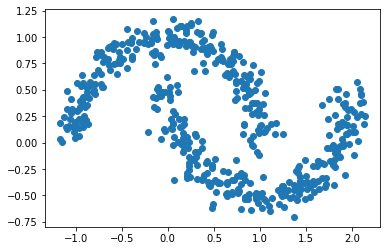

In [29]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

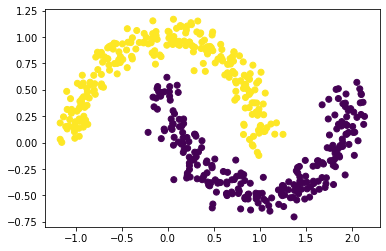

In [30]:
clusters1 = dbscan(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters1)
plt.show()

Референс:

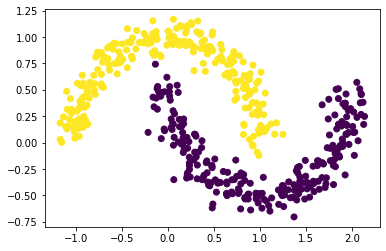

In [31]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [165]:
from sklearn.datasets import make_circles
X2, _ = make_circles(n_samples=500, noise = 0.1)

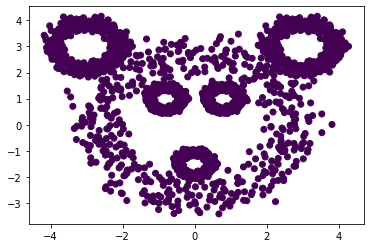

In [171]:
dbscan1 =  dbscan(eps=0.2, min_samples=10)
clusters = dbscan1.fit_predict(X2)

plt.scatter(X2[:,0]-3, X2[:,1]+3, c = clusters)
plt.scatter(X2[:,0]+3, X2[:,1]+3, c = clusters)
plt.scatter(X2[:,0]*3, X2[:,1]*3, c = clusters)
plt.scatter(X2[:,0]*0.5+0.8, X2[:,1]*0.5 + 1,  c = clusters)
plt.scatter(X2[:,0]*0.5-0.8, X2[:,1]*0.5 + 1,  c = clusters)
plt.scatter(X2[:,0]*0.5, X2[:,1]*0.5 - 1.5,  c = clusters)
plt.show()

Получился очень страшный, но медвежонок.

Или хотя бы что-нибудь такое: 

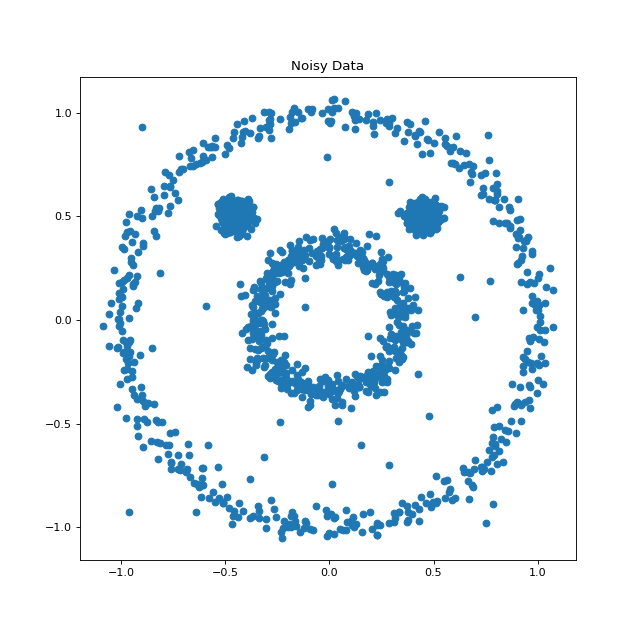

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [142]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 11.8 ms


In [143]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 59.8 ms
